## Poroelastic equations solver for fluid content formulation


- Implicit 2D finite-difference scheme for diffusion equation following Beck and Kaus (2020): https://www-udc.ig.utexas.edu/external/becker/Geodynamics557.pdf

- Current set up is for a poroelastic medium with zero displacements ($u=0$) and change in fluid mass ($\Delta m = 0$) at all boundaries. A fixed fluid flux is prescribed at the center of the domain.

In [1]:
from matplotlib import rcParams
rcParams['font.family'] = 'Avenir'
rcParams['font.size'] = 10
import matplotlib.pyplot as plt
from matplotlib import cm
#%matplotlib widget
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import inv
import time

In [2]:
# Physical parameters
L = 10000 # Width of domain [m]
H = 10000 # Height of domain [m]
#r = 500 # radius over which flux is applied [m]

# Elastic & poroelastic properties
G = 1e9 # Shear modulus [GPa]
nu = 0.25 # Drained Poisson's ratio
nu_u = 0.4 # Undrained Poisson's ratio
biot_coeff = 0.9 # Biot coefficient
M = 2*G*(nu_u-nu)/((biot_coeff**2)*(1-2*nu_u)*(1-2*nu)) # Biot Modulus

# Hydrologic properties
rho_o = 1000 # Reference water density [kg/m^3]
g = 10 # gravitational acceleration
K = 1.5e-4 # Hydraulic conductivity of firn [m/s]
S = (1-nu_u)*(1-2*nu)/(M*(1-nu)*(1-2*nu_u))*rho_o*g
# Storage coefficient (a function of elastic and poroelastic parameters) [1/m]
c = K/S # Hydraulic diffusivity [m^2/s]

q = 0.0001 #input flux over radius r [kg/m^4]

# Numerical parameters
dt = 2.5e3 # timestep [s]
nx = 50 # gridpoints in x-direction
nz = 50 # gridpoints in z-direction
nt = 30 # Number of timesteps to compute
dx = L/(nx-1) # Spacing of grid in x-direction
dz = H/(nz-1) # Spacing of grid in z-direction
[x2d,z2d]= np.meshgrid(np.arange(-L/2,L/2+dx,dx),np.arange(-H,0+dz,dz))
x = x2d[1,:]
z = z2d[:,1]
Number = np.arange(0,nx*nz) 
Number = Number.reshape(x2d.shape) # Array of indices

# Setup arrays for modeled variables:
delta_m = np.zeros(z2d.shape) # Change in fluid mass \delta_m [kg/m^3 of aquifer]
u = np.zeros(z2d.shape) # Horizontal displacements [m]
v = np.zeros(z2d.shape) # Vertical displacements [m]

In [3]:
# Construct the matrix of finite-difference coefficients for the diffusion equation:
A = np.eye(nx*nz)
sx = c*dt/dx**2
sz = c*dt/dz**2

for i in np.arange(1,nz-1):
    for j in np.arange(1,nx-1):
        #if i == 0:                                     #Set up A for bottom flux boundary
            # A[Number[i,j],Number[i+1,j]] = -2*sz
            # A[Number[i,j],Number[i,j+1]] = -sx
            # A[Number[i,j],Number[i,j]] = 1+2*sz+2*sx
            # A[Number[i,j],Number[i,j-1]] = -sx
        #elif i == nz-1:                                #Set up A for top flux boundary
            # A[Number[i,j],Number[i,j+1]] = -sx
            # A[Number[i,j],Number[i,j]] = 1+2*sz+2*sx
            # A[Number[i,j],Number[i-1,j]] = -2*sz
            # A[Number[i,j],Number[i,j-1]] = -sx
        #else:                                          #Set up the main A matrix
        A[Number[i,j],Number[i+1,j]] = -sz
        A[Number[i,j],Number[i,j+1]] = -sx
        A[Number[i,j],Number[i,j]] = 1+2*sz+2*sx
        A[Number[i,j],Number[i-1,j]] = -sz
        A[Number[i,j],Number[i,j-1]] = -sx

A_sparse = csr_matrix(A)
A_inv = inv(A_sparse) # Take the inverse of the constant A matrix

/Users/stacylarochelle/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:347: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/Users/stacylarochelle/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:239: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


In [4]:
# Construct the matrix of finite-difference coefficients for the mechanical equations

A_top_left = np.eye(nx*nz)     # 1's on the diagonal are to set fixed boundary conditions for horizontal displacements at the top and bottom
A_bot_right = np.eye(nx*nz)    # 1's on the diagonal are to set fixed boundary conditions for vertical displacements at the top and bottom
A_top_right = np.zeros((nx*nz,nx*nz))
A_bot_left = np.zeros((nx*nz,nx*nz))

for i in np.arange(1,nz-1):
    for j in np.arange(1,nx-1):
        A_top_left[Number[i,j],Number[i+1,j]] = 1/dz**2
        A_top_left[Number[i,j],Number[i,j+1]] = (1+1/(1-2*nu_u))*(1/dx**2)
        A_top_left[Number[i,j],Number[i,j]] = -2*((1+1/(1-2*nu_u))*(1/dx**2)+1/dz**2)
        A_top_left[Number[i,j],Number[i-1,j]] = 1/dz**2
        A_top_left[Number[i,j],Number[i,j-1]] = (1+1/(1-2*nu_u))*(1/dx**2)
        
for i in np.arange(1,nz-1):
    for j in np.arange(1,nx-1):
        A_top_right[Number[i,j],Number[i+1,j+1]] = (1/(1-2*nu_u))*(1/(4*dx*dz))
        A_top_right[Number[i,j],Number[i-1,j+1]] = -(1/(1-2*nu_u))*(1/(4*dx*dz))
        A_top_right[Number[i,j],Number[i+1,j-1]] = -(1/(1-2*nu_u))*(1/(4*dx*dz))
        A_top_right[Number[i,j],Number[i-1,j-1]] = (1/(1-2*nu_u))*(1/(4*dx*dz))

for i in np.arange(1,nz-1):
    for j in np.arange(1,nx-1):
        A_bot_left[Number[i,j],Number[i+1,j+1]] = (1/(1-2*nu_u))*(1/(4*dx*dz))
        A_bot_left[Number[i,j],Number[i-1,j+1]] = -(1/(1-2*nu_u))*(1/(4*dx*dz))
        A_bot_left[Number[i,j],Number[i+1,j-1]] = -(1/(1-2*nu_u))*(1/(4*dx*dz))
        A_bot_left[Number[i,j],Number[i-1,j-1]] = (1/(1-2*nu_u))*(1/(4*dx*dz))
        
for i in np.arange(1,nz-1):
    for j in np.arange(1,nx-1):
        A_bot_right[Number[i,j],Number[i+1,j]] = (1+1/(1-2*nu_u))*(1/dz**2)
        A_bot_right[Number[i,j],Number[i,j+1]] = 1/dx**2
        A_bot_right[Number[i,j],Number[i,j]] = -2*((1+1/(1-2*nu_u))*(1/dz**2)+1/dx**2)
        A_bot_right[Number[i,j],Number[i-1,j]] = (1+1/(1-2*nu_u))*(1/dz**2)
        A_bot_right[Number[i,j],Number[i,j-1]] = 1/dx**2
        
A_top = np.concatenate((A_top_left,A_top_right),axis=1)
A_bot = np.concatenate((A_bot_left,A_bot_right),axis=1)
A_poro = np.concatenate((A_top,A_bot))

A_poro = A_poro*G

A_poro_sparse = csr_matrix(A_poro)
A_poro_inv = inv(A_poro_sparse)    

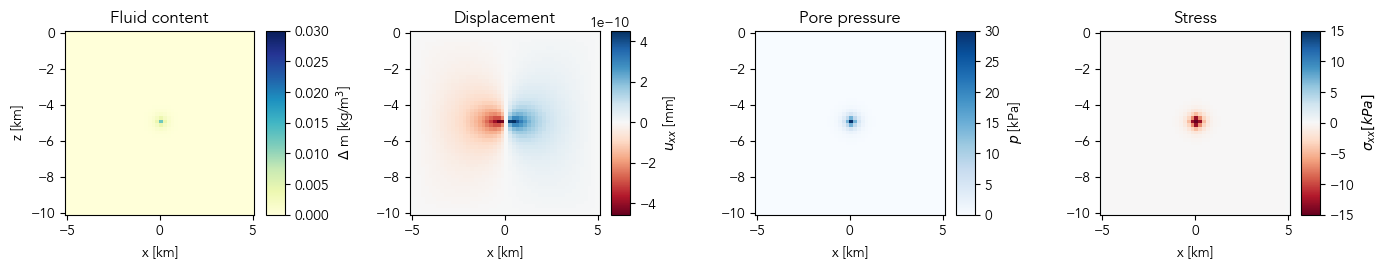

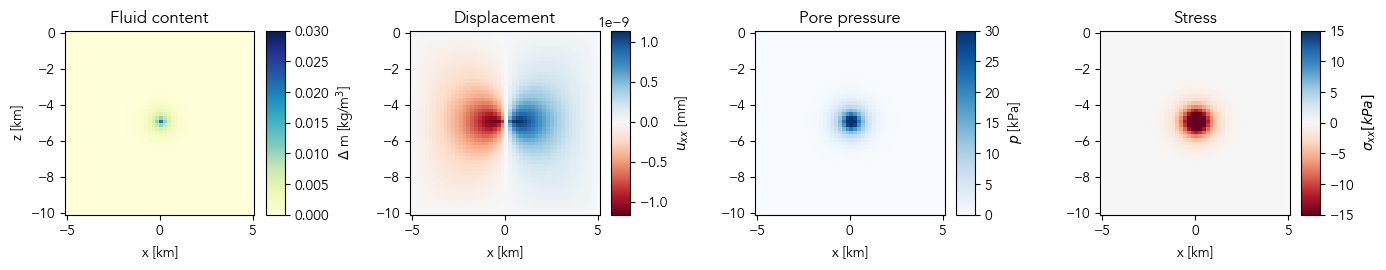

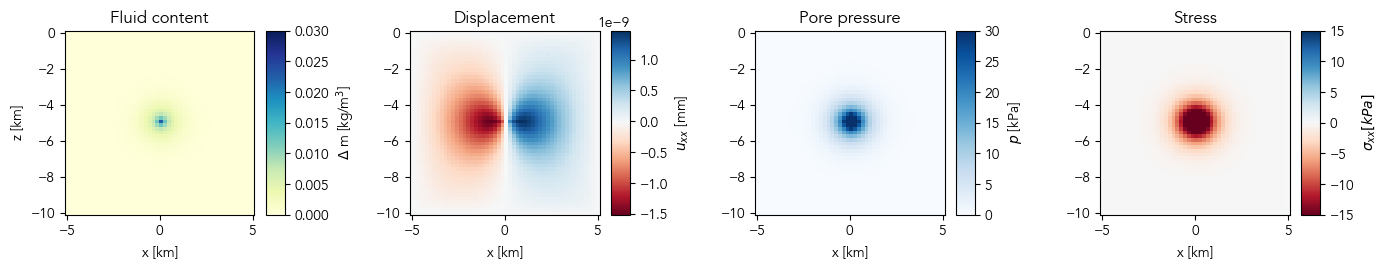

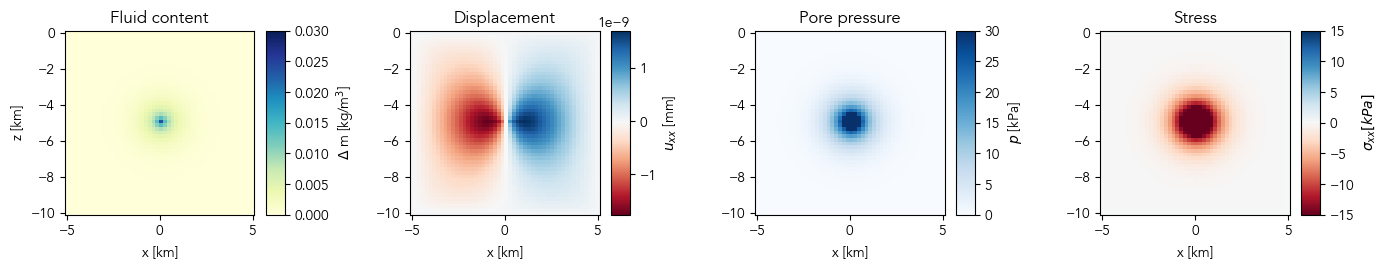

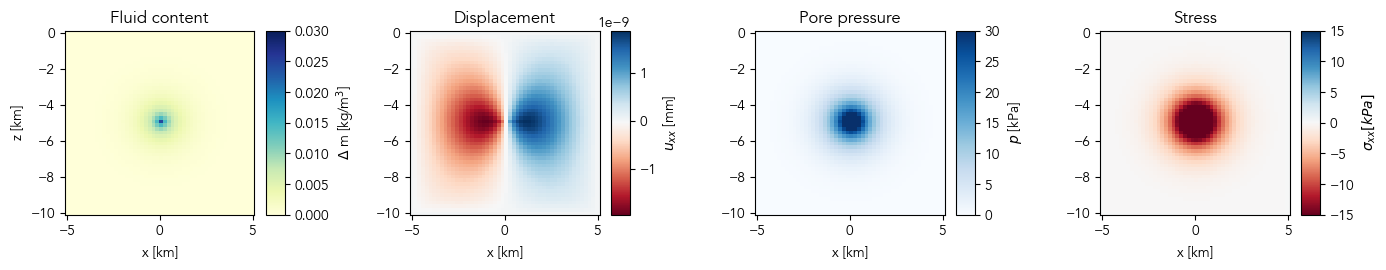

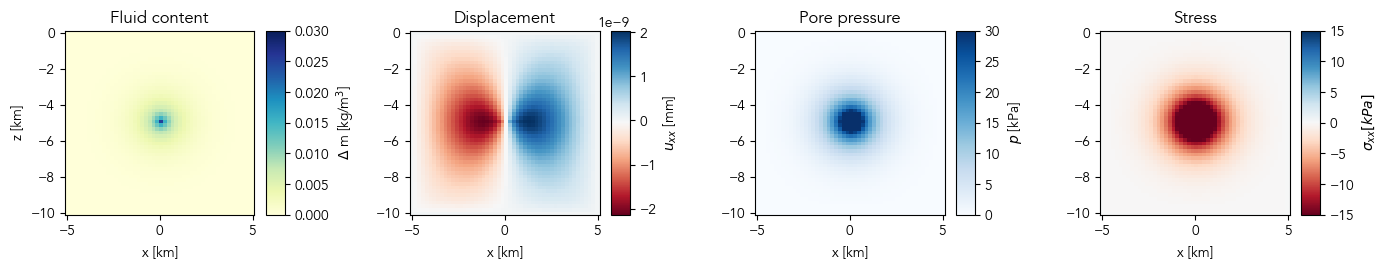

In [5]:
# Main loop over time:

delta_m_stored = np.zeros([nt,nx]) # Array to store a profile at each time step
time = 0

for n in np.arange(0,nt):
    # Solve diffusion equation:
    delta_m[int(nx/2),int(nz/2)]=delta_m[int(nx/2),int(nz/2)]+2*sz*dz*q # Prescribed fluid flux at the center of the domain
    # Set zero flux on all sides: 
    delta_m[1,:] = 0
    delta_m[nx-1,:] = 0
    delta_m[:,1] = 0
    delta_m[:,nz-1] = 0
    
    rhs = delta_m.flatten()        # Set right-hand side of the equation to delta_m at time = n-1

    delta_m_vector = A_inv*rhs     # compute solution vector
    delta_m = delta_m_vector.reshape(x2d.shape)
    delta_m_stored[n,:]=delta_m[int(nz/2),:]   #Store delta_m profile at each time step.
    
    # Solve mechanical equations:
    uv_vector = np.concatenate((u.flatten(),v.flatten())) # Vector containing horizontal and vertical displacements
    
    delta_m_dx = np.zeros(z2d.shape)
    delta_m_dz = np.zeros(z2d.shape)
    
    for i in np.arange(1,nz-1):
        for j in np.arange(1,nx-1):
            delta_m_dx[i,j] = (delta_m[i,j+1]-delta_m[i,j-1])/(2*dx)
            delta_m_dz[i,j] = (delta_m[i+1,j]-delta_m[i-1,j])/(2*dz)
    
    # RHS vector containing the delta_m gradients in the x and z directions:
    rhs_poro = biot_coeff*M/1e9*(1/rho_o)*np.concatenate((delta_m_dx.flatten(),delta_m_dz.flatten())) 
    uv_vector = A_poro_inv*rhs_poro
    u_vector = uv_vector[0:nx*nz]
    v_vector = uv_vector[nx*nz:2*nx*nz]
    u = u_vector.reshape(x2d.shape)
    v = v_vector.reshape(x2d.shape)
    
    zeta = delta_m/rho_o
    
    # Compute strains & stress:
    strain_xx = np.zeros(x2d.shape)
    strain_zz = np.zeros(x2d.shape)
    strain_xz = np.zeros(x2d.shape)
    strain_kk = np.zeros(x2d.shape)
    stress_xx = np.zeros(x2d.shape)
    stress_xx_eff = np.zeros(x2d.shape)
    stress_zz = np.zeros(x2d.shape)
    stress_xz = np.zeros(x2d.shape)
    stress_kk = np.zeros(x2d.shape)
    p = np.zeros(x2d.shape)
    
    for i in np.arange(1,nz-1):
        for j in np.arange(1,nx-1):
            strain_xx[i,j] = (u[i,j+1]-u[i,j-1])/(2*dx)
            strain_zz[i,j] = (v[i+1,j]-v[i-1,j])/(2*dz)
            strain_xz[i,j] = 0.5*((u[i+1,j]-u[i-1,j])/(2*dz)+(v[i,j+1]-v[i,j-1])/(2*dx))
            strain_kk[i,j] = strain_xx[i,j]+strain_zz[i,j]
            stress_xx[i,j] = 2*G*strain_xx[i,j]+2*G*nu_u/(1-2*nu_u)*strain_kk[i,j]-biot_coeff*M*zeta[i,j]
            p[i,j] = M*(zeta[i,j]-biot_coeff*strain_kk[i,j])
            stress_xx_eff[i,j] = stress_xx[i,j] + biot_coeff*p[i,j]

    # Update time:
    time = time + dt
    
    #Plots
    if np.mod(n,5)==0: 

        fig, ax = plt.subplots(1,4,figsize = (14,2.8))

        p1 = ax[0].pcolor(x2d/1e3,z2d/1e3,delta_m,cmap='YlGnBu',shading = 'auto',vmin=0,vmax=0.03)
        ax[0].set_xlabel("x [km]")
        ax[0].set_ylabel("z [km]")
        ax[0].set_title('Time = '+str(round(time/3600/24))+' days')
        cb = plt.colorbar(p1,ax=ax[0],aspect = 10)
        cb.set_label(label='$\Delta$ m [kg/m$^3$]')
        ax[0].set_title("Fluid content")
        
        p2 = ax[1].pcolor(x2d/1e3,z2d/1e3,u*1e3,cmap='RdBu',shading = 'auto')#,vmin=-2.5,vmax=2.5)
        ax[1].set_xlabel("x [km]")
        cb = plt.colorbar(p2,ax=ax[1],aspect = 10)
        cb.set_label(label='$u_{xx}$ [mm]')
        ax[1].set_title("Displacement")
        
        p3 = ax[2].pcolor(x2d/1e3,z2d/1e3,p/1e3,cmap='Blues',shading = 'auto',vmin=0,vmax=30)
        ax[2].set_xlabel("x [km]")
        cb = plt.colorbar(p3,ax=ax[2],aspect = 10)
        cb.set_label(label='$p$ [kPa]')
        ax[2].set_title("Pore pressure")
        
        p4 = ax[3].pcolor(x2d/1e3,z2d/1e3,stress_xx/1e3,cmap='RdBu',shading = 'auto',vmin=-15,vmax=15)
        ax[3].set_xlabel("x [km]")
        cb = plt.colorbar(p4,ax=ax[3],aspect = 10)
        cb.set_label(label='$\sigma_{xx} [kPa]$')
        ax[3].set_title("Stress")

        plt.tight_layout()

        plt.show()
    
#plt.savefig('test.png',dpi=400)

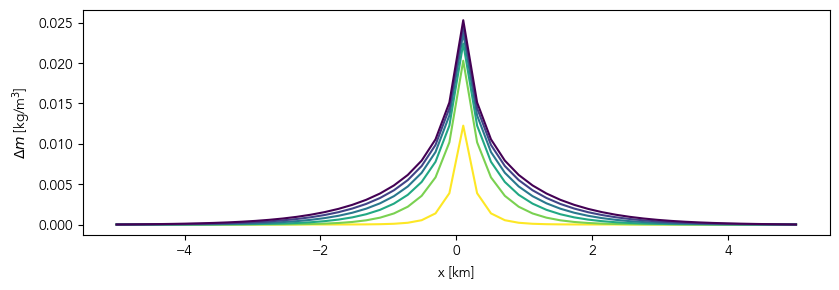

In [6]:
#Plot evolution of profiles over time

dt_plot = 5

fig, ax = plt.subplots(figsize = (8.5,3))

color = iter(cm.viridis_r(np.linspace(0, 1, int(nt/dt_plot))))

for i in range(0,nt,dt_plot):
    c = next(color)
    ax.plot(x/1e3,delta_m_stored[i,:], c=c)
    
ax.set_xlabel("x [km]")
ax.set_ylabel("$\Delta m$ [kg/m$^3$]")
plt.tight_layout()

plt.show()  